In [1]:
import torch
from math import sqrt 
import matplotlib.pyplot as plt

from torchfem.io import import_mesh, export_mesh


## A simple tensile specimen

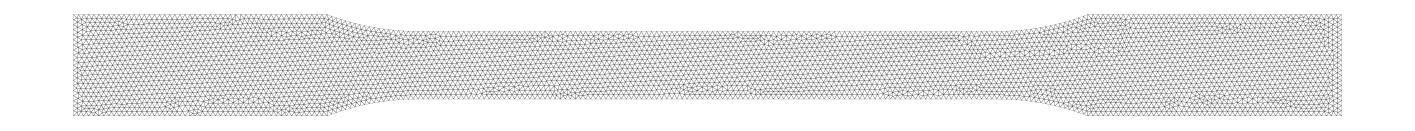

In [2]:
# Material model (plane stress)
E = 72000.0
nu = 0.2
C = (E / ((1.0 + nu) * (1.0 - 2.0 * nu))) * torch.tensor(
    [[1.0 - nu, nu, 0.0], [nu, 1.0 - nu, 0.0], [0.0, 0.0, 0.5 - nu]]
)

# Import mesh
specimen = import_mesh("../meshes/tensile.vtu", C=C)
specimen.plot(linewidth=0.1, figsize=(18,10))

# Fixed end BCs
left = (specimen.nodes[:, 0] < 0.1)
specimen.constraints[left, 0] = True
specimen.constraints[left & (torch.abs(specimen.nodes[:, 1]) < 0.1), 1] = True

# Loaded end BCs
right = (specimen.nodes[:, 0] >= 149.9)
specimen.constraints[right, 0] = True
specimen.displacements[right, 0] = 5.0

## Mesh morphing with radial basis functions

In [3]:
# Radial basis function
r = torch.cdist(specimen.nodes, specimen.nodes)
epsilon = 0.4
phi = torch.exp(-((epsilon * r) ** 2))

def morph(fem, nids, x, dir):
    # Build matrix
    M = phi[:, nids]
    M = M[nids, :]

    # Solve linear equation system
    weights = torch.linalg.solve(M, x - fem.nodes[nids, dir])

    # Apply deformation
    for weight, node in zip(weights, nids):
        fem.nodes[:, dir] += weight * phi[node, :]

## Shape optimization

In [4]:
def box_constrained_decent(func, x_init, x_lower, x_upper, eta=0.1, max_iter=100, tol=1E-10):
    x = x_init.clone().requires_grad_()
    for i in range(max_iter):
        x_old = x.clone()
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.max(torch.min(x, x_upper), x_lower)
        if torch.norm(x-x_old) < tol:
            print(f"Box constrained decent reached tolerance {tol} after {i} steps.")
            return x
    print(f"Box constrained decent reached maximum iteration count {max_iter}.")
    return x


def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    f_k = func(x_k)

    def approximation(x):
        res = f_k * torch.ones_like(x[..., 0])
        for j, grad in enumerate(grads):
            if grad < 0.0:
                p = 0
                q = -((x_k[j] - L_k[j]) ** 2) * grad
            else:
                p = (U_k[j] - x_k[j]) ** 2 * grad
                q = 0
            res -= p / (U_k[j] - x_k[j]) + q / (x_k[j] - L_k[j])
            res += p / (U_k[j] - x[..., j]) + q / (x[..., j] - L_k[j])
        return res

    return approximation

Objective function

In [5]:
control_nodes = [137, 142, 264, 269, 403, 408, 530, 535]

def f(x):
    # Update nodes
    morph(specimen, control_nodes, x, 1)
    # Solve fem with updated nodes
    u_k, _ = specimen.solve()
    # Compute stress
    sigma = specimen.compute_stress(u_k)
    mises = torch.sqrt(sigma[:,0]**2 - sigma[:,0]*sigma[:,1] + sigma[:,1]**2 +3 * sigma[:,2]**2)
    # Return top 20 stresses
    top20 = torch.topk(mises, 20)[0]
    return top20.sum()

In [6]:
def optimize(x_0, x_min, x_max, iter):
    s = 0.5

    # Set up lists for L, U, x
    L = []
    U = []
    x = [x_0]
    objective = [f(x_0)]

    for k in range(iter):
        print(f"Iteration {k}")
        # Update asymptotes with heuristic procedure
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            U_k = torch.zeros_like(U[k - 1])
            for j in range(len(L_k)):
                if (x[k][j] - x[k - 1][j]) * (x[k - 1][j] - x[k - 2][j]) < 0.0:
                    L_k[j] = x[k][j] - s * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + s * (U[k - 1][j] - x[k - 1][j])
                else:
                    L_k[j] = x[k][j] - 1.0 / sqrt(s) * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + 1.0 / sqrt(s) * (U[k - 1][j] - x[k - 1][j])
            L.append(L_k)
            U.append(U_k)
        else:
            L.append(x[k] - s * (x_max - x_min))
            U.append(x[k] + s * (x_max - x_min))

        # Compute lower move limit in this step
        x_min_k = torch.maximum(x_min, 0.9 * L[k] + 0.1 * x[k])
        x_max_k = torch.minimum(x_max, 0.9 * U[k] + 0.1 * x[k])

        # Compute the current approximation function and save gradients
        f_tilde = MMA(f, x[k], L[k], U[k])

        # Compute the maximum of the dual function
        x_star = box_constrained_decent(f_tilde, x_0, x_min_k, x_max_k, eta=0.0001)

        # Compute current optimal point with dual solution
        x.append(x_star)
        objective.append(f(x_star).detach())

    return x, objective

In [7]:
# Bounds on variables
x_0 = specimen.nodes[control_nodes, 1]
x_min = x_0 - 0.5
x_max = x_0 + 0.5

x_opt, f_opt = optimize(x_0, x_min, x_max, 15)

Iteration 0
Box constrained decent reached tolerance 1e-10 after 36 steps.
Iteration 1
Box constrained decent reached tolerance 1e-10 after 1 steps.
Iteration 2
Box constrained decent reached tolerance 1e-10 after 1 steps.
Iteration 3
Box constrained decent reached tolerance 1e-10 after 2 steps.
Iteration 4
Box constrained decent reached tolerance 1e-10 after 2 steps.
Iteration 5
Box constrained decent reached tolerance 1e-10 after 2 steps.
Iteration 6
Box constrained decent reached tolerance 1e-10 after 1 steps.
Iteration 7
Box constrained decent reached tolerance 1e-10 after 2 steps.
Iteration 8
Box constrained decent reached tolerance 1e-10 after 2 steps.
Iteration 9
Box constrained decent reached tolerance 1e-10 after 2 steps.
Iteration 10
Box constrained decent reached tolerance 1e-10 after 2 steps.
Iteration 11
Box constrained decent reached tolerance 1e-10 after 2 steps.
Iteration 12
Box constrained decent reached tolerance 1e-10 after 2 steps.
Iteration 13
Box constrained decen

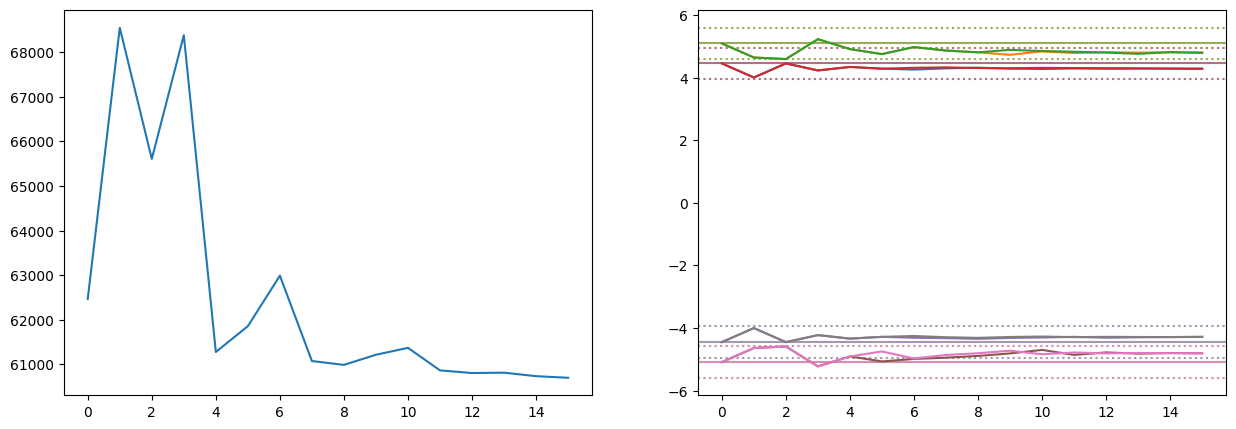

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax[0].plot(f_opt)
for x0, xmin, xmax, color in zip(x_0, x_min, x_max, colors):
    ax[1].axhline(x0, color=color, alpha=0.5)
    ax[1].axhline(xmin, color=color, alpha=0.5, linestyle=":")
    ax[1].axhline(xmax, color=color, alpha=0.5, linestyle=":")
ax[1].plot(torch.stack(x_opt).detach())
plt.show()

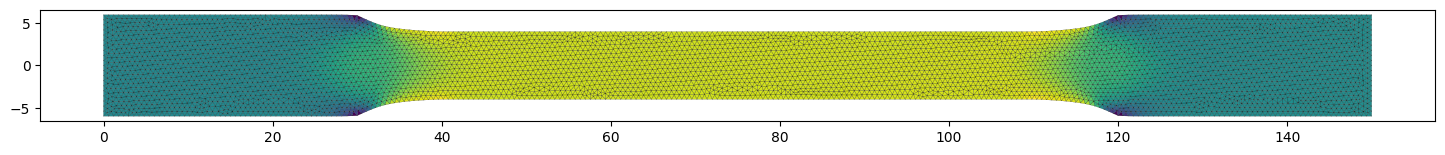

In [9]:
u, _ = specimen.solve()
sigma = specimen.compute_stress(u)
mises = torch.sqrt(sigma[:,0]**2 + sigma[:,1]**2 - sigma[:,0]*sigma[:,1])
specimen.plot(axes=True, bcs=False, element_property=mises, linewidth=0.1, figsize=(18,3))

In [10]:
export_mesh(specimen, "../meshes/tensile_optimal_shape.vtu", nodal_data={"Displacement": u}, elem_data={"Stress": [sigma]})

Warning: VTU requires 3D points, but 2D points given. Appending 0 third component.